## All Subsets Regression


It is possible to run through all of the possible combinations of predictors and 
generate the metrics we are most interested in.  We'll present some code below 
for finding the best model for each number of predictors.

In [1]:

import pandas as pd
import numpy as np
import itertools
import time
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [103]:
# read in the data to dataframe called ames
ames = pd.read_csv("https://webpages.charlotte.edu/mschuck1/classes/DTSC2301/Data/Ames_house_prices.csv", na_values=['?'])
# replace the ? in the data with NaN for missing values
ames.replace([' ?'],np.nan)
# show information about the dataframe
ames.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

Here we apply the best subset selection approach to the Ames Housing data. We
wish to predict the Sale Price based upon a variety of features/predictors.

In [104]:
#print(ames.columns)
ames_df=ames[['LotArea','OverallQual','YearBuilt','BsmtFinSF1','GrLivArea','YrSold','GarageArea','PoolArea']]

In [105]:
X=ames_df
y=ames['SalePrice']

We can perform best subset selection by identifying the best model that contains a given number of predictors, where **best** is quantified using RMSE. We'll define a helper function to outputs the best set of variables for each model size.

In [106]:
# create a function called processSubset to fit the models and return information about
# the model as well as the RMSE
def processSubset(feature_set):
    # Fit model on feature_set and calculate RSS
    #X=sm.add_constant(X[list(feature_set)])
    model = sm.OLS(y,sm.add_constant(X[list(feature_set)]))
    regr = model.fit()
    RMSE = np.sqrt(((regr.predict(sm.add_constant(X[list(feature_set)])) - y) ** 2).mean())
    return {"model":regr, "RMSE":RMSE}

In [107]:
def getBest(k):
    # start tracking the time 
    tic = time.time()
    # create an array to put the results
    results = []
    
    # do all combinations of predictors 
    for combo in itertools.combinations(X.columns, k):
        results.append(processSubset(combo))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the smallest RMSE
    best_model = models.loc[models['RMSE'].argmin()]
    
    # stop tracking the time
    toc = time.time()
    print("Processed", models.shape[0], "models on", k, "predictors in", (toc-tic), "seconds.")
    
    # Return the best model, along with some other useful information about the model
    return best_model

This returns a `DataFrame` containing the best model that we generated, along with some extra information about the model. Now we want to call that function for each number of predictors $k$:

In [108]:
# Could take quite awhile to complete...

models_best = pd.DataFrame(columns=["RMSE", "model"])

tic = time.time()
for i in range(1,7):
    models_best.loc[i] = getBest(i)

toc = time.time()
print("Total elapsed time:", (toc-tic), "seconds.")

Processed 8 models on 1 predictors in 0.03051900863647461 seconds.
Processed 28 models on 2 predictors in 0.13299965858459473 seconds.
Processed 56 models on 3 predictors in 0.23412108421325684 seconds.
Processed 70 models on 4 predictors in 0.2997307777404785 seconds.
Processed 56 models on 5 predictors in 0.24488162994384766 seconds.
Processed 28 models on 6 predictors in 0.14878034591674805 seconds.
Total elapsed time: 1.0986967086791992 seconds.


Now we have one big `DataFrame` that contains the best models we've generated for each number of predictors along with their RMSE:

In [109]:
models_best

,RMSE,model
1,48589.447121,<statsmodels.regression.linear_model.Regressio...
2,42457.614768,<statsmodels.regression.linear_model.Regressio...
3,40028.06666,<statsmodels.regression.linear_model.Regressio...
4,38726.063529,<statsmodels.regression.linear_model.Regressio...
5,37992.154854,<statsmodels.regression.linear_model.Regressio...
6,37510.699984,<statsmodels.regression.linear_model.Regressio...


If we want to access the details of each model, no problem! We can get a full rundown of a single model using the `summary()` function:

In [110]:
# here is the best model with 2 predictors is counted as a predictor
print(models_best.loc[2, "model"].summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.714
Model:                            OLS   Adj. R-squared:                  0.714
Method:                 Least Squares   F-statistic:                     1820.
Date:                Wed, 19 Feb 2025   Prob (F-statistic):               0.00
Time:                        10:15:57   Log-Likelihood:                -17630.
No. Observations:                1460   AIC:                         3.527e+04
Df Residuals:                    1457   BIC:                         3.528e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -1.041e+05   5045.372    -20.631      

This output indicates that the best two-variable model
contains only `OverallQual` and `GrLivArea`. To save time, we only generated results
up to the best 6-variable model. You can use the functions we defined above to explore as many variables as are desired.

In [111]:
# Show the best 8-variable model 
print(getBest(8)["model"].summary())

Processed 1 models on 8 predictors in 0.010203361511230469 seconds.
                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.778
Model:                            OLS   Adj. R-squared:                  0.776
Method:                 Least Squares   F-statistic:                     633.9
Date:                Wed, 19 Feb 2025   Prob (F-statistic):               0.00
Time:                        10:15:57   Log-Likelihood:                -17447.
No. Observations:                1460   AIC:                         3.491e+04
Df Residuals:                    1451   BIC:                         3.496e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------

Rather than letting the results of our call to the `summary()` function print to the screen, we can access just the parts we need using the model's attributes. For example, if we want the $R^2$ value:

In [112]:
models_best.loc[5, "model"].rsquared

0.7711348952180305

Excellent! In addition to the verbose output we get when we print the summary to the screen, fitting the `OLM` also produced many other useful statistics such as adjusted $R^2$, AIC, and BIC. We can examine these to try to select the best overall model. Let's start by looking at $R^2$ across all our models:

In [113]:
# Gets the second element from each row ('model') and pulls out its rsquared attribute
models_best.apply(lambda row: row[1].rsquared, axis=1)

/tmp/ipykernel_16949/3287597919.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  models_best.apply(lambda row: row[1].rsquared, axis=1)


1    0.625652
2    0.714173
3    0.745949
4    0.762207
5    0.771135
6    0.776899
dtype: float64

As expected, the $r^2$ statistic increases monotonically as more
variables are included.  This happens even if the added predictor has little value; that's 
part of the reason that we introduced $r^2_{adj}$.

Plotting RSS, adjusted $r^2$, AIC, and BIC for all of the models at once will
help us decide which model to select. 

Akaike's Information Criterion (AIC) and Bayesian Information Criterion (BIC) are two other metrics for penalizing extra terms in a model.  While $r^2_{adj}$ works well for regression,
AIC and BIC are more general for a larger class of models.  For both AIC and BIC we want the smallest values we can get. 

/tmp/ipykernel_16949/1196503365.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  rsquared_adj = models_best.apply(lambda row: row[1].rsquared_adj, axis=1)
/tmp/ipykernel_16949/1196503365.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  aic = models_best.apply(lambda row: row[1].aic, axis=1)
/tmp/ipykernel_16949/1196503365.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  bic = models_best.apply(lambda row: row[1].bic, axi

Text(0, 0.5, 'BIC')

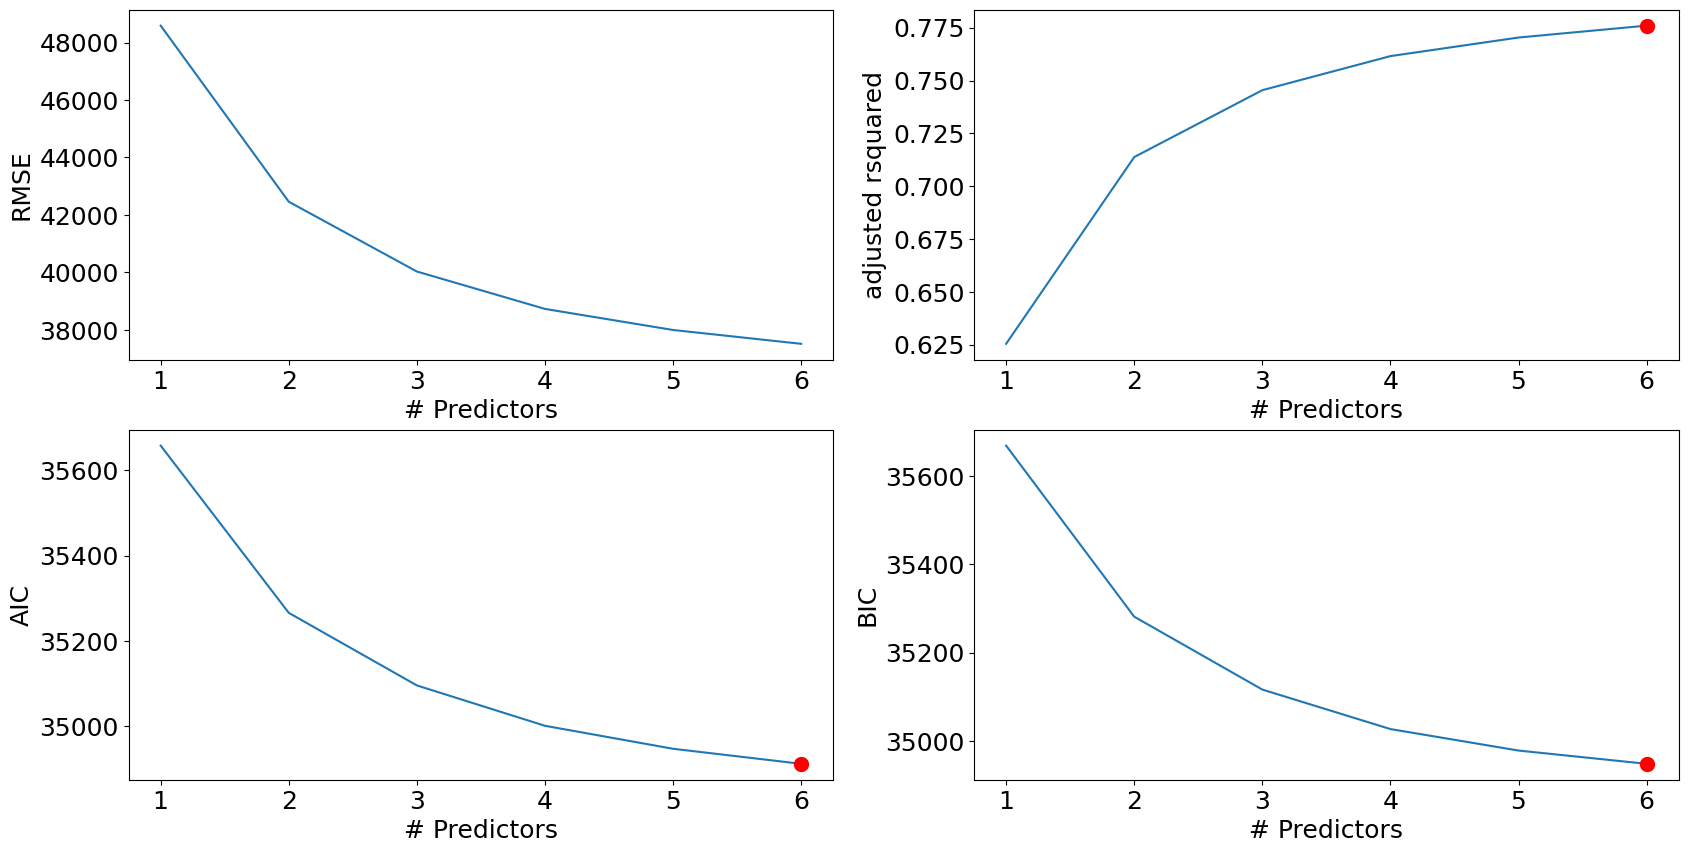

In [114]:
plt.figure(figsize=(20,10))
plt.rcParams.update({'font.size': 18, 'lines.markersize': 10})

# Set up a 2x2 grid so we can look at 4 plots at once
plt.subplot(2, 2, 1)

# We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
# The argmax() function can be used to identify the location of the maximum point of a vector
plt.plot(models_best["RMSE"])
plt.xlabel('# Predictors')
plt.ylabel('RMSE')

# We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
# The argmax() function can be used to identify the location of the maximum point of a vector

rsquared_adj = models_best.apply(lambda row: row[1].rsquared_adj, axis=1)

plt.subplot(2, 2, 2)
plt.plot(rsquared_adj)
plt.plot(rsquared_adj.argmax()+1, rsquared_adj.max(), "or")
plt.xlabel('# Predictors')
plt.ylabel('adjusted rsquared')

# We'll do the same for AIC and BIC, this time looking for the models with the SMALLEST statistic
aic = models_best.apply(lambda row: row[1].aic, axis=1)

plt.subplot(2, 2, 3)
plt.plot(aic)
plt.plot(aic.argmin()+1, aic.min(), "or")
plt.xlabel('# Predictors')
plt.ylabel('AIC')

bic = models_best.apply(lambda row: row[1].bic, axis=1)

plt.subplot(2, 2, 4)
plt.plot(bic)
plt.plot(bic.argmin()+1, bic.min(), "or")
plt.xlabel('# Predictors')
plt.ylabel('BIC')

Recall that in the second step of our selection process, we narrowed the field down to just one model on any $k<=p$ predictors. We see that according to BIC, the best performer is the model with 6 variables.  Again, no one measure is going to give us an entirely accurate picture... but they all agree that a model with 6 predictors is pretty good.

### Penguins

In [115]:
penguins = pd.read_csv("https://webpages.charlotte.edu/mschuck1/classes/DTSC2301/Data/penguins.csv", na_values=['NA'])
# remove rows with missing data
penguins.dropna(inplace=True)
penguins.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female,2007
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,male,2007


In [116]:
# make indicator/dummy variables for species
# each species gets a different column
one_hot=pd.get_dummies(penguins['species'],dtype=int)
print(one_hot)
penguins=penguins.join(one_hot)
penguins.head()

     Adelie  Chinstrap  Gentoo
0         1          0       0
1         1          0       0
2         1          0       0
4         1          0       0
5         1          0       0
..      ...        ...     ...
339       0          1       0
340       0          1       0
341       0          1       0
342       0          1       0
343       0          1       0

[333 rows x 3 columns]


,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year,Adelie,Chinstrap,Gentoo
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007,1,0,0
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007,1,0,0
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007,1,0,0
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female,2007,1,0,0
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,male,2007,1,0,0


In [117]:
# interactions of bill_depth_mm with Species
penguins['billDepth_Adelie'] = penguins['bill_depth_mm']*penguins['Adelie']
penguins['billDepth_Chinstrap'] = penguins['bill_depth_mm']*penguins['Chinstrap']

# interactions of flipper_length_mm with Species
penguins['flipper_Adelie'] = penguins['flipper_length_mm']*penguins['Adelie']
penguins['flipper_Chinstrap'] = penguins['flipper_length_mm']*penguins['Chinstrap']

# interactions of bill_length_mm with Species
penguins['billLength_Adelie'] = penguins['bill_length_mm']*penguins['Adelie']
penguins['billLength_Chinstrap'] = penguins['bill_length_mm']*penguins['Chinstrap']

In [118]:

X = penguins[['bill_depth_mm','bill_length_mm','flipper_length_mm','Adelie','Chinstrap','billDepth_Adelie',
              'billDepth_Chinstrap','billLength_Adelie','billLength_Chinstrap','flipper_Adelie','flipper_Chinstrap']]
y = penguins['body_mass_g']

In [119]:
# Could take quite awhile to complete...

models_best = pd.DataFrame(columns=["RMSE", "model"])

tic = time.time()
for i in range(1,11):
    models_best.loc[i] = getBest(i)

toc = time.time()
print("Total elapsed time:", (toc-tic), "seconds.")

Processed 11 models on 1 predictors in 0.06653213500976562 seconds.
Processed 55 models on 2 predictors in 0.13375616073608398 seconds.
Processed 165 models on 3 predictors in 0.5952286720275879 seconds.
Processed 330 models on 4 predictors in 1.2938246726989746 seconds.
Processed 462 models on 5 predictors in 2.0318655967712402 seconds.
Processed 462 models on 6 predictors in 1.6439483165740967 seconds.
Processed 330 models on 7 predictors in 1.197983980178833 seconds.
Processed 165 models on 8 predictors in 0.785881519317627 seconds.
Processed 55 models on 9 predictors in 0.22210478782653809 seconds.
Processed 11 models on 10 predictors in 0.045859575271606445 seconds.
Total elapsed time: 8.0403151512146 seconds.


Looking at the 

In [120]:
models_best.apply(lambda row: row[1].rsquared_adj, axis=1)

/tmp/ipykernel_16949/2147299205.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  models_best.apply(lambda row: row[1].rsquared_adj, axis=1)


1     0.761373
2     0.780569
3     0.824929
4     0.837163
5     0.851874
6     0.852069
7     0.852336
8     0.852144
9     0.851964
10    0.851511
dtype: float64

Looking at this output we can see that $r^2_{adj}$ rises until we have 7 predictors and then begins to drop.  Let's look at that model.

In [121]:
# Show the best 7-predictor model, the one with the highest r^2 adjusted
print(getBest(7)["model"].summary())

Processed 330 models on 7 predictors in 1.3379409313201904 seconds.
                            OLS Regression Results                            
Dep. Variable:            body_mass_g   R-squared:                       0.855
Model:                            OLS   Adj. R-squared:                  0.852
Method:                 Least Squares   F-statistic:                     274.8
Date:                Wed, 19 Feb 2025   Prob (F-statistic):          2.25e-132
Time:                        10:16:07   Log-Likelihood:                -2378.1
No. Observations:                 333   AIC:                             4772.
Df Residuals:                     325   BIC:                             4803.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------

Note the std err for _Chinstrap_ that is very large and suggests multicollinearity.

In [122]:
# Show the best 5-predictor model, the one with the highest r^2 adjusted
print(getBest(5)["model"].summary())

Processed 462 models on 5 predictors in 2.0909016132354736 seconds.
                            OLS Regression Results                            
Dep. Variable:            body_mass_g   R-squared:                       0.854
Model:                            OLS   Adj. R-squared:                  0.852
Method:                 Least Squares   F-statistic:                     382.9
Date:                Wed, 19 Feb 2025   Prob (F-statistic):          2.63e-134
Time:                        10:16:09   Log-Likelihood:                -2379.7
No. Observations:                 333   AIC:                             4771.
Df Residuals:                     327   BIC:                             4794.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------

/tmp/ipykernel_16949/1196503365.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  rsquared_adj = models_best.apply(lambda row: row[1].rsquared_adj, axis=1)
/tmp/ipykernel_16949/1196503365.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  aic = models_best.apply(lambda row: row[1].aic, axis=1)
/tmp/ipykernel_16949/1196503365.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  bic = models_best.apply(lambda row: row[1].bic, axi

Text(0, 0.5, 'BIC')

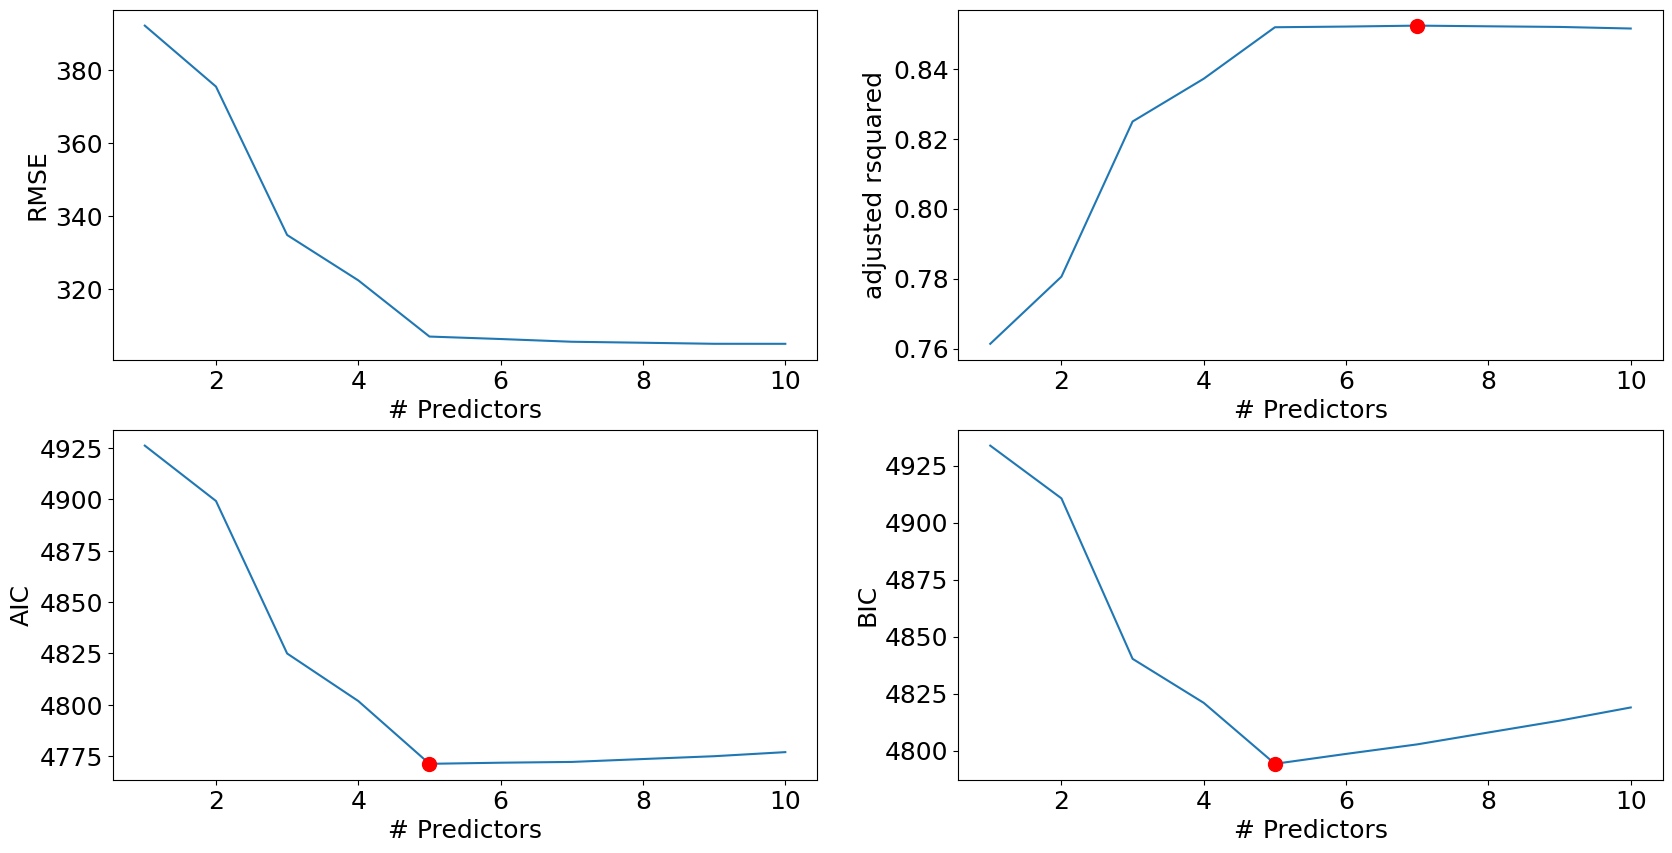

In [123]:
plt.figure(figsize=(20,10))
plt.rcParams.update({'font.size': 18, 'lines.markersize': 10})

# Set up a 2x2 grid so we can look at 4 plots at once
plt.subplot(2, 2, 1)

# We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
# The argmax() function can be used to identify the location of the maximum point of a vector
plt.plot(models_best["RMSE"])
plt.xlabel('# Predictors')
plt.ylabel('RMSE')

# We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
# The argmax() function can be used to identify the location of the maximum point of a vector

rsquared_adj = models_best.apply(lambda row: row[1].rsquared_adj, axis=1)

plt.subplot(2, 2, 2)
plt.plot(rsquared_adj)
plt.plot(rsquared_adj.argmax()+1, rsquared_adj.max(), "or")
plt.xlabel('# Predictors')
plt.ylabel('adjusted rsquared')

# We'll do the same for AIC and BIC, this time looking for the models with the SMALLEST statistic
aic = models_best.apply(lambda row: row[1].aic, axis=1)

plt.subplot(2, 2, 3)
plt.plot(aic)
plt.plot(aic.argmin()+1, aic.min(), "or")
plt.xlabel('# Predictors')
plt.ylabel('AIC')

bic = models_best.apply(lambda row: row[1].bic, axis=1)

plt.subplot(2, 2, 4)
plt.plot(bic)
plt.plot(bic.argmin()+1, bic.min(), "or")
plt.xlabel('# Predictors')
plt.ylabel('BIC')

So while $r^2_{adj}$ suggested that we consider a model with 7 predictors, AIC and BIC preferred the best model with 5 predictors.  

#### Next Steps
In the model building process we would not be finished.  As we noted from the plot above our metrics are not in agreement.  We should investigate the models that have values near the highest for $r^2_{adj}$ or the lowest for AIC and BIC.  So we should look at the best models with 5 predictors and the best models with 7 predictors.  And likely the best model with 6 predictors.

There are also other considerations for our models.  Namely, does the regression meet the conditions for using this kind of model and how does the model perform out of sample, that is via cross-validation.  

Model building is not a linear process.  We get some models to consider from all subsets regression but we are not finished.  We should investigate further the attributes of the models and develop new models.  

As many of you found with Project 1, at some point you have to decide this is the best model that I have and go with it OR don't because it is not of sufficient quality.  (Hope you didn't do the latter on Project 1.)

Also this process is just for linear regression not for spline regression or local regression or 
GAMs.  

### Tasks

1. Read in the bluejay data.  For this analysis we'll only use the quantitative variables plus 'Sex' 


In [124]:

bluejay_df = pd.read_csv("https://webpages.charlotte.edu/mschuck1/classes/DTSC2301/Data/BlueJays.csv")
# set new data frame to only columns i will be using
bluejay = bluejay_df[['BillDepth', 'BillWidth', 'BillLength', 'Head', 'Mass', 'Skull', 'Sex']] 
bluejay.head()

,BillDepth,BillWidth,BillLength,Head,Mass,Skull,Sex
0,8.26,9.21,25.92,56.58,73.30,30.66,1
1,8.54,8.76,24.99,56.36,75.10,31.38,1
2,8.39,8.78,26.07,57.32,70.25,31.25,1
3,7.78,9.30,23.48,53.77,65.50,30.29,0
4,8.71,9.84,25.47,57.32,74.90,31.85,1



2. Create interactions for 'Sex' and each of the other quantitative variables


In [125]:
# create interactions for 'Sex' and each of the other quantitative variables    
bluejay['BillDepth_Sex'] = bluejay['BillDepth']*bluejay['Sex']
bluejay['BillWidth_Sex'] = bluejay['BillWidth']*bluejay['Sex']
bluejay['BillLength_Sex'] = bluejay['BillLength']*bluejay['Sex']
bluejay['Head_Sex'] = bluejay['Head']*bluejay['Sex']
bluejay['Mass_Sex'] = bluejay['Mass']*bluejay['Sex']
bluejay['Skull_Sex'] = bluejay['Skull']*bluejay['Sex']

bluejay.head()

/tmp/ipykernel_16949/2091120362.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bluejay['BillDepth_Sex'] = bluejay['BillDepth']*bluejay['Sex']
/tmp/ipykernel_16949/2091120362.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bluejay['BillWidth_Sex'] = bluejay['BillWidth']*bluejay['Sex']


,BillDepth,BillWidth,BillLength,Head,Mass,Skull,Sex,BillDepth_Sex,BillWidth_Sex,BillLength_Sex,Head_Sex,Mass_Sex,Skull_Sex
0,8.26,9.21,25.92,56.58,73.30,30.66,1,8.26,9.21,25.92,56.58,73.30,30.66
1,8.54,8.76,24.99,56.36,75.10,31.38,1,8.54,8.76,24.99,56.36,75.10,31.38
2,8.39,8.78,26.07,57.32,70.25,31.25,1,8.39,8.78,26.07,57.32,70.25,31.25
3,7.78,9.30,23.48,53.77,65.50,30.29,0,0.00,0.00,0.00,0.00,0.00,0.00
4,8.71,9.84,25.47,57.32,74.90,31.85,1,8.71,9.84,25.47,57.32,74.90,31.85



3. Find the best regression models of up to size 8 and generate the plot of our model metrics vs the number of predictors.


In [126]:
X2 = bluejay[['BillDepth', 'BillWidth', 'BillLength', 'Head', 'Skull', 'Sex']]
y2 = bluejay['Mass']
# create a function called processSubset to fit the models and return information about
# the model as well as the RMSE
def processSubset(feature_set):
    # Fit model on feature_set and calculate RSS
    #X=sm.add_constant(X[list(feature_set)])
    model2 = sm.OLS(y2,sm.add_constant(X2[list(feature_set)]))
    regr2 = model2.fit()
    RMSE2 = np.sqrt(((regr2.predict(sm.add_constant(X2[list(feature_set)])) - y2) ** 2).mean())
    return {"model":regr2, "RMSE":RMSE2}

    

In [127]:
def getBest(k):
    # start tracking the time 
    tic = time.time()
    # create an array to put the results
    results2 = []
    
    # do all combinations of predictors 
    for combo in itertools.combinations(X2.columns, k):
        results2.append(processSubset(combo))
    
    # Wrap everything up in a nice dataframe
    models2 = pd.DataFrame(results2)
    
    # Choose the model with the smallest RMSE
    best_model2 = models2.loc[models2['RMSE'].argmin()]
    
    # stop tracking the time
    toc = time.time()
    print("Processed", models2.shape[0], "models on", k, "predictors in", (toc-tic), "seconds.")
    
    # Return the best model, along with some other useful information about the model
    return best_model2

In [128]:
# Could take quite awhile to complete...

models_best2 = pd.DataFrame(columns=["RMSE", "model"])

tic = time.time()
for i in range(1,9):
    models_best2.loc[i] = getBest(i)

toc = time.time()
print("Total elapsed time:", (toc-tic), "seconds.")

Processed 6 models on 1 predictors in 0.03511667251586914 seconds.
Processed 15 models on 2 predictors in 0.062178611755371094 seconds.
Processed 20 models on 3 predictors in 0.04324650764465332 seconds.
Processed 15 models on 4 predictors in 0.03578901290893555 seconds.
Processed 6 models on 5 predictors in 0.014204263687133789 seconds.
Processed 1 models on 6 predictors in 0.0022864341735839844 seconds.


KeyError: 'RMSE'

In [ ]:
models_best2

,RMSE,model
1,0.0,<statsmodels.regression.linear_model.Regressio...
2,0.0,<statsmodels.regression.linear_model.Regressio...
3,0.0,<statsmodels.regression.linear_model.Regressio...
4,0.0,<statsmodels.regression.linear_model.Regressio...
5,0.0,<statsmodels.regression.linear_model.Regressio...
6,0.0,<statsmodels.regression.linear_model.Regressio...
7,0.0,<statsmodels.regression.linear_model.Regressio...
8,0.0,<statsmodels.regression.linear_model.Regressio...



4. Which size of model do $r^2_{adj}$, AIC and BIC recommend?

5. Get summaries for each of the models in Task 4 and investigate each model.  From just looking at the summaries which model would you investigate first and why?

6. Investigate the model you chose in Task 5 and determine if the linear regression conditions are met for that model.